In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='24h',
    price_calculation='close',
)

In [3]:
environment_columns = ['price', 'RSI_14', 'Momentum_7', 'ATR_7', 'ADX_7_14', 'TSI_5_10', 'KelChM_5', 'KelChU_5', 'KelChD_5']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.momentum(df, 7)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    df = pandas_techinal_indicators.true_strength_index(df, 5, 10)
    df = pandas_techinal_indicators.keltner_channel(df, 5)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [4]:
price_data = add_features(price_data.copy())

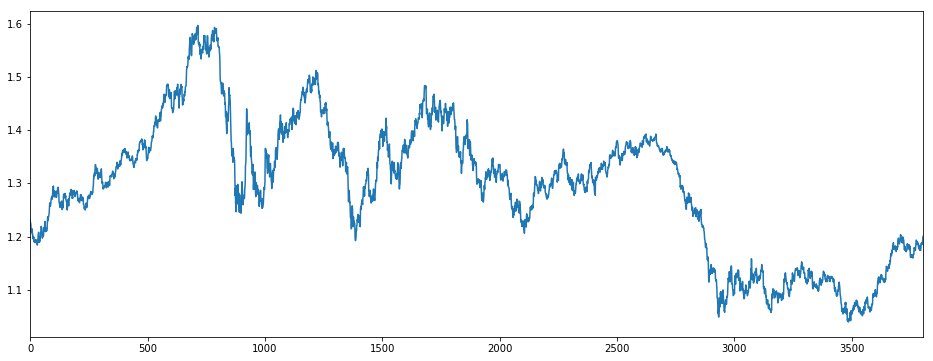

In [5]:
price_data['price'].plot(figsize=(16,6))

In [6]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 2536, test size 1268


In [7]:
episode=1000
batch_size=10

In [8]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,Momentum_7,ATR_7,ADX_7_14,TSI_5_10,KelChM_5,KelChU_5,KelChD_5
0,0,2006-01-23,1.2304,1.23220,1.21640,1.2167,1.2304,0.758386,0.0140,0.009556,0.343613,0.364371,1.214517,1.223653,1.205381
1,1,2006-01-24,1.2265,1.23110,1.22572,1.2304,1.2265,0.758386,0.0147,0.008510,0.365054,0.381773,1.217812,1.226256,1.209368
2,2,2006-01-25,1.2244,1.23232,1.22362,1.2264,1.2244,0.699771,0.0136,0.008557,0.327176,0.351404,1.221369,1.230109,1.212629
3,3,2006-01-26,1.2213,1.22692,1.21980,1.2244,1.2213,0.602097,0.0106,0.008197,0.343388,0.276896,1.223799,1.231959,1.215639
4,4,2006-01-27,1.2094,1.22352,1.20876,1.2213,1.2094,0.410861,0.0004,0.009840,0.357055,0.047740,1.223491,1.233843,1.213139


In [9]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [10]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: 2397 pips, median trade count: 329
....................
episode: 40/1000
median profit: 4336 pips, median trade count: 284
....................
episode: 60/1000
median profit: 5611 pips, median trade count: 272
....................
episode: 80/1000
median profit: 6213 pips, median trade count: 280
....................
episode: 100/1000
median profit: 6716 pips, median trade count: 295
....................
episode: 120/1000
median profit: 7682 pips, median trade count: 306
....................
episode: 140/1000
median profit: 8412 pips, median trade count: 320
....................
episode: 160/1000
median profit: 9496 pips, median trade count: 329
....................
episode: 180/1000
median profit: 10243 pips, median trade count: 329
....................
episode: 200/1000
median profit: 10812 pips, median trade count: 340
....................
episode: 220/1000
median profit: 11474 pips, median trade count: 349
....................

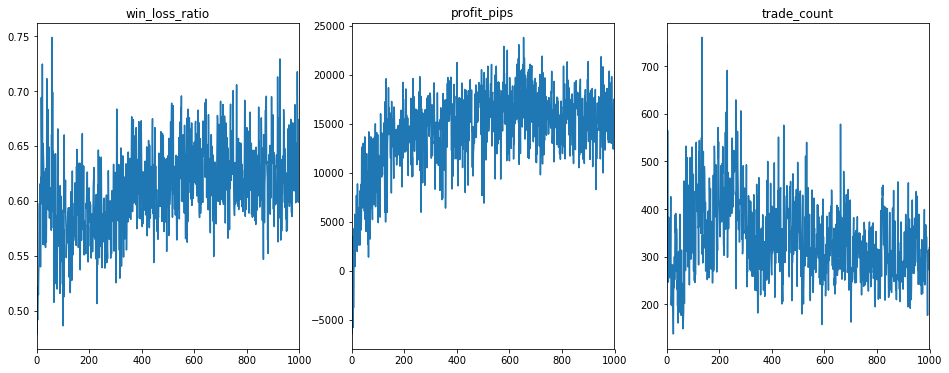

In [11]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [12]:
joblib.dump(agent, 'trained-model-24h-spread.pkl') 

['trained-model-24h-spread.pkl']

## Test

In [13]:
# Uncomment to load agent from file 
# agent = joblib.load('trained-model-24h-spread.pkl')  

In [14]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [15]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [16]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 1666.7249999999376 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13b43f110>]],
      dtype=object)

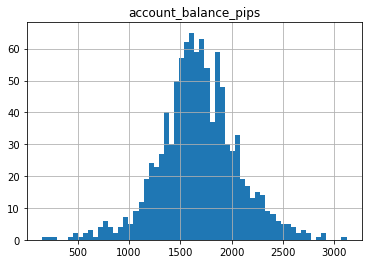

In [17]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

## Analyse positions on test data

In [18]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [19]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [20]:
env._stats()

{'trade_count': 155,
 'win_loss_ratio': 0.5225806451612903,
 'account_balance': 0.08348499999999492,
 'unrealised_pl': -0.026125000000000176}

In [28]:
position_data = env.price_data.copy()

In [29]:
position_data['position'] = position_data['position'] - 1

In [30]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

157 positions to plot...


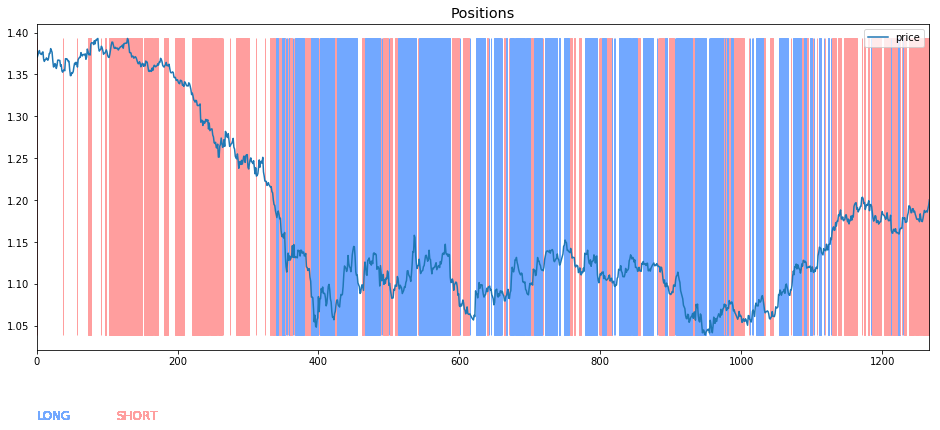

In [31]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [32]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 51.59%
Ratio of long to short positions: 0.77
Median profit: 0.0
Total profit: 0.06906000000000212
Median position length: 3.0
Number of trades: 157


In [33]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2013-12-06,1.37062,2013-12-08,1.37066,1,NaN,NaN,False,NaN
1,2014-01-19,1.35272,2014-01-20,1.35460,1,-1.0,-0.00188,False,-0.00188
2,2014-02-11,1.36366,2014-02-13,1.36760,2,-1.0,-0.00394,False,-0.00582
3,2014-03-02,1.37746,2014-03-07,1.38784,5,-1.0,-0.01038,False,-0.01620
4,2014-03-23,1.37970,2014-03-25,1.38201,2,-1.0,-0.00231,False,-0.01851
...,...,...,...,...,...,...,...,...,...
152,2017-11-16,1.17782,2017-11-21,1.17418,4,-1.0,0.00364,True,0.07125
153,2017-11-24,1.19325,2017-12-04,1.18679,8,-1.0,0.00646,True,0.07771
154,2017-12-05,1.18305,2017-12-12,1.17426,6,-1.0,0.00879,True,0.08650
155,2017-12-13,1.18364,2017-12-15,1.17503,2,-1.0,0.00861,True,0.09511


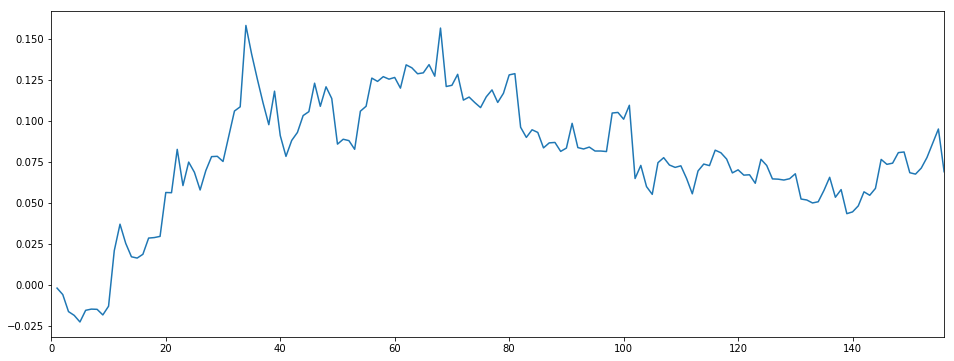

In [34]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.1310799999999993


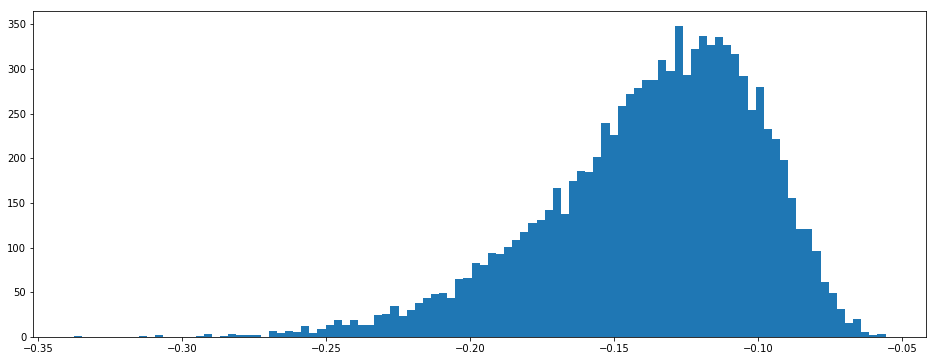

In [35]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);